Besu IBFT2.0 Log Data Analysis

In [3]:
import pandas as pd
import numpy as np
import csv, warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

def log2csv(log_file: str):
    with open(log_file, 'r') as file:
        lines = file.read().splitlines()
        csv_lines = [x.split(' | ') for x in lines]
        csv_file = log_file.replace('.log', '.csv')
        with open(csv_file, 'w+') as csv_file:
            w = csv.writer(csv_file)
            w.writerows(csv_lines)

def parse_log(log_file: str) -> pd.DataFrame:
    log2csv(log_file)
    csv_file = log_file.replace('.log', '.csv')
    header = ['Timestamp', 'Process', 'LogLevel', 'LogSource', 'Description']
    df_besu = pd.read_csv(csv_file, parse_dates=['Timestamp'], names=header).dropna()
    df_besu['Timestamp'] = pd.to_datetime(df_besu.Timestamp, infer_datetime_format=True, utc=True)
    
    df_ibftround = df_besu[df_besu.LogSource == 'IbftRound']
    df_temp = df_ibftround.loc[:, 'Description'].str.split('\. round=ConsensusRoundIdentifier', expand=True)
    df_ibftround.loc[:, 'Action'] = df_temp[0].values
    df_ibftround.loc[:, 'Order'] = df_temp[1].values
    df_des = df_ibftround.Order.str.split('Sequence=', expand=True)[1].str.split('\, Round=', expand=True)
    df_ibftround.loc[:, 'Sequence'] = df_des[0].astype(int)
    df_ibftround.loc[:, 'Round'] = df_des[1].str.split('\}', expand=True)[0].astype(int)

    df_ibftround.reset_index(inplace=True)
    df_ibftround.drop(columns=['index', 'Description','Order'], axis=1, inplace=True)
    return df_ibftround

def gen_logs_df(logpath, networksize=4):
    df_list = []
    for i in range(networksize):
        log_file = '{}/besu-{}.log'.format(logpath,i+1)
        df = parse_log(log_file)
        df['Node'] = i+1
        df_list.append(df)
    df = pd.concat(df_list)
    return df

def cal_time_delta(send: str, receive: str, df: pd.DataFrame) -> list:
    t_delta_ls = []
    sequences = df.Sequence.unique()
    for seq in sequences:
        df_seq = df.loc[df.Sequence == seq]
        if send in df_seq.Action.unique() and 'proposed' in send:
            c_time = pd.to_datetime(df_seq[df_seq.Action == send].Timestamp.values[0], utc=True)
            df_r = df_seq.loc[df_seq.Action == receive]
            for _, row in df_r.iterrows():
                t_delta = pd.to_datetime(row.Timestamp, utc=True) - c_time
                t_delta_ls.append(t_delta.total_seconds())
        else:
            df_send = df_seq.loc[df_seq.Action == send].sort_values('Timestamp')
            df_receive = df_seq.loc[df_seq.Action == receive].reset_index()
            sendNodes = len(df_send.Node.unique())
            receiveNodes = len(df_receive.Node.unique())
            if sendNodes == receiveNodes or sendNodes+1 == receiveNodes:
                ts = []
                for node in df_receive.Node.unique():
                    t = list(pd.to_datetime(df_receive.loc[df_receive.Node == node].Timestamp.values, utc=True))
                    ts.append(t)
                for _, row in df_send.iterrows():
                    sts = pd.to_datetime(row.Timestamp, utc=True)
                    for i in range(len(ts)):
                        if (row.Node != (i+1)) and ts[i]:
                            rts = ts[i].pop(0)
                            deltatime = (rts - sts).total_seconds()
                            t_delta_ls.append(deltatime)
    return t_delta_ls

# def cal_prep_trans_time(df: pd.DataFrame) -> list:
#     ts_ls = []
#     sequences = df.Sequence.unique()
#     for seq in sequences:
#         df_send = df.loc[(df.Sequence == seq) & (df.Action == 'Sending prepare message')].sort_values('Timestamp')
#         df_receive = df.loc[(df.Sequence == seq) & (df.Action == 'Received a prepare message')].reset_index()
#         if len(df_send.Node.unique())+1 == len(df_receive.Node.unique()):
#             ts = []
#             for node in df_receive.Node.unique():
#                 t = list(pd.to_datetime(df_receive.loc[df_receive.Node == node].Timestamp.values, utc=True))
#                 ts.append(t)
#             for _, row in df_send.iterrows():
#                 sts = pd.to_datetime(row.Timestamp, utc=True)
#                 for i in range(len(ts)):
#                     if (row.Node != (i+1)) and ts[i]:
#                         rts = ts[i].pop(0)
#                         deltatime = (rts - sts).total_seconds()
#                         ts_ls.append(deltatime)
#     return ts_ls

# def cal_commit_trans_time(df: pd.DataFrame) -> list:
#     ts_ls = []
#     sequences = df.Sequence.unique()
#     for seq in sequences:
#         df_send = df.loc[(df.Sequence == seq) & (df.Action == 'Sending commit message')].sort_values('Timestamp')
#         df_receive = df.loc[(df.Sequence == seq) & (df.Action == 'Received a commit message')].reset_index()
#         if len(df_send.Node.unique()) == len(df_receive.Node.unique()):
#             ts = []
#             for node in df_receive.Node.unique():
#                 t = list(pd.to_datetime(df_receive.loc[df_receive.Node == node].Timestamp.values, utc=True))
#                 ts.append(t)
#             for _, row in df_send.iterrows():
#                 sts = pd.to_datetime(row.Timestamp, utc=True)
#                 for i in range(len(ts)):
#                     if (row.Node != (i+1)) and ts[i]:
#                         rts = ts[i].pop(0)
#                         deltatime = (rts - sts).total_seconds()
#                         ts_ls.append(deltatime)
#     return ts_ls

def cal_process_time(df):
    t_process_proposal, t_process_prepare, t_process_commit = [], [], []
    sequences = df.Sequence.unique()
    for seq in sequences:
        df_seq = df.loc[df.Sequence == seq]
        for _, row in df_seq.iterrows():
            if row.Action == 'Received a proposal message':
                rts_prop = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Sending prepare message':
                sts_prep = pd.to_datetime(row.Timestamp, utc=True)
                t_process_proposal.append((sts_prep - rts_prop).total_seconds())
            if row.Action == 'Received a prepare message':
                rts_prep = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Sending commit message':
                sts_commit = pd.to_datetime(row.Timestamp, utc=True)
                t_process_prepare.append((sts_commit - rts_prep).total_seconds())
            if row.Action == 'Received a commit message':
                rts_commit = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Importing block to chain':
                sts_import = pd.to_datetime(row.Timestamp, utc=True)
                t_process_commit.append((sts_import - rts_commit).total_seconds())
    return t_process_proposal, t_process_prepare, t_process_commit

def cal_consensus_time(df: pd.DataFrame) -> list:
    consensus_time = []
    for seq in df.Sequence.unique():
        df_seq = df.loc[(df.Sequence == seq) & ((df.Action.str.contains('block') | df.Action.str.contains('proposal')))].sort_values('Timestamp')
        ts = df_seq.Timestamp.values
        delta_t = pd.Timedelta(ts[-1] - ts[0]).total_seconds()
        consensus_time.append(delta_t)
    return consensus_time

def plot_hist(ts, ax=None, upper=50, bins=50, title='Frequency Histogram', xlabel='Time (ms)', ylabel='Frequency'):
    '''
    ts: time list in seconds
    upper: upper threshold in milliseconds
    bins: number of bins in histogram plot
    '''
    ax = ax or plt.gca()
    x = [1000*t for t in ts if t>0 and 1000*t<upper]
    hist = ax.hist(x, bins=bins)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    return hist

In [2]:
log_path1 = '../data/logs-20211215-141843-4c-8gb'
df1 = gen_logs_df(logpath=log_path1)
log_path2 = '../data/logs-20211215-154842-2c-4gb'
df2 = gen_logs_df(logpath=log_path2)
log_path3 = '../data/logs-20211215-171026-8c-8gb'
df3 = gen_logs_df(logpath=log_path3)

In [31]:
df1.loc[df1.Sequence == 2]

,Timestamp,Process,LogLevel,LogSource,Action,Sequence,Round,Node
7,2021-12-15 20:10:45.027000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a proposal message,2,0,1
8,2021-12-15 20:10:45.034000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending prepare message,2,0,1
9,2021-12-15 20:10:45.046000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,2,0,1
10,2021-12-15 20:10:45.047000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending commit message,2,0,1
11,2021-12-15 20:10:45.056000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,2,0,1
12,2021-12-15 20:10:45.059000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a commit message,2,0,1
13,2021-12-15 20:10:45.066000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a commit message,2,0,1
14,2021-12-15 20:10:45.067000+00:00,pool-9-thread-1,DEBUG,IbftRound,Importing block to chain,2,0,1
7,2021-12-15 20:10:45.012000+00:00,pool-9-thread-1,DEBUG,IbftRound,Creating proposed block,2,0,2
8,2021-12-15 20:10:45.039000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,2,0,2


In [35]:
df = df1.loc[df1.Sequence == 2]
df.loc[df.Action == 'Importing block to chain'].sort_values('Timestamp').Timestamp.values[0]

numpy.datetime64('2021-12-15T20:10:45.051000000')

In [3]:
send_str, receive_str = 'Creating proposed block', 'Received a proposal message'
ts_pro_trans_4c8gb = cal_time_delta(send=send_str, receive=receive_str, df=df1)
ts_pro_trans_2c4gb = cal_time_delta(send=send_str, receive=receive_str, df=df2)
ts_pro_trans_8c8gb = cal_time_delta(send=send_str, receive=receive_str, df=df3)

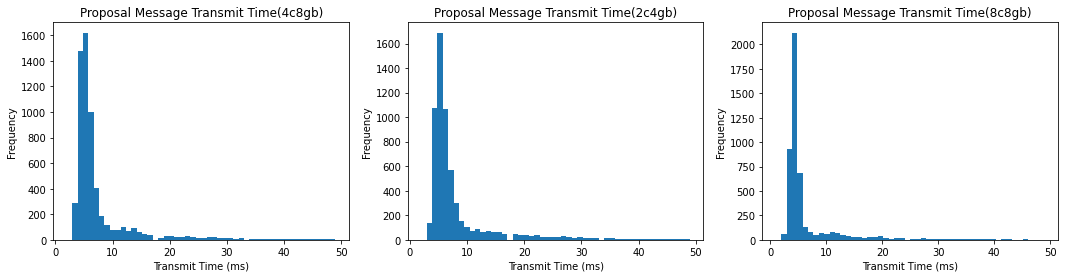

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Proposal Message Transmit Time'
plot_hist(ts_pro_trans_4c8gb, axs[0], 50, title+'(4c8gb)')
plot_hist(ts_pro_trans_2c4gb, axs[1], 50, title+'(2c4gb)')
plot_hist(ts_pro_trans_8c8gb, axs[2], 50, title+'(8c8gb)')

plt.show()

In [32]:
# ts_prep_trans_4c8gb = cal_prep_trans_time(df1)
# ts_prep_trans_2c4gb = cal_prep_trans_time(df2)
# ts_prep_trans_8c8gb = cal_prep_trans_time(df3)

In [4]:
send_str, receive_str = 'Sending prepare message', 'Received a prepare message'
ts_prep_trans_4c8gb = cal_time_delta(send=send_str, receive= receive_str, df=df1)
ts_prep_trans_2c4gb = cal_time_delta(send=send_str, receive= receive_str, df=df2)
ts_prep_trans_8c8gb = cal_time_delta(send=send_str, receive= receive_str, df=df3)

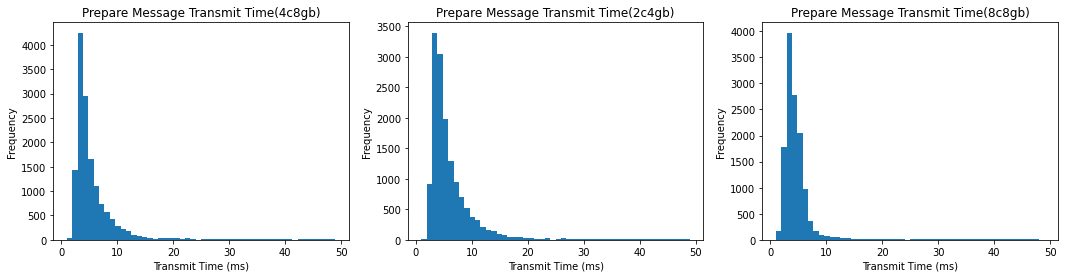

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Prepare Message Transmit Time'
plot_hist(ts_prep_trans_4c8gb, axs[0], 50, title+'(4c8gb)')
plot_hist(ts_prep_trans_2c4gb, axs[1], 50, title+'(2c4gb)')
plot_hist(ts_prep_trans_8c8gb, axs[2], 50, title+'(8c8gb)')

plt.show()

In [ ]:
# ts_commit_trans_4c8gb = cal_commit_trans_time(df1)
# ts_commit_trans_2c4gb = cal_commit_trans_time(df2)
# ts_commit_trans_8c8gb = cal_commit_trans_time(df3)

In [5]:
send_str, receive_str = 'Sending commit message', 'Received a commit message'
ts_commit_trans_4c8gb = cal_time_delta(send=send_str, receive= receive_str, df=df1)
ts_commit_trans_2c4gb = cal_time_delta(send=send_str, receive= receive_str, df=df2)
ts_commit_trans_8c8gb = cal_time_delta(send=send_str, receive= receive_str, df=df3)

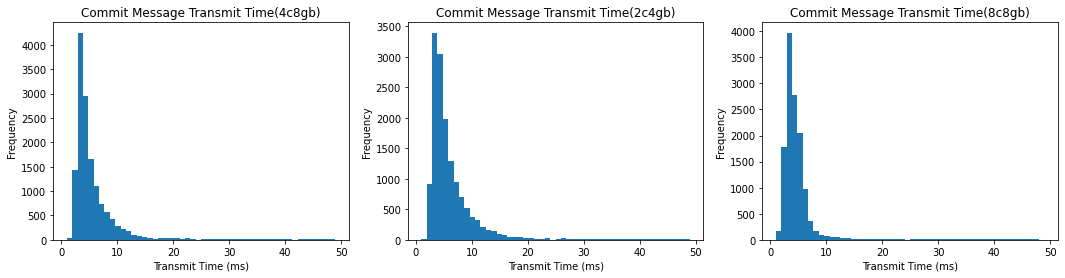

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Commit Message Transmit Time'
plot_hist(ts_prep_trans_4c8gb, axs[0], 50, title+'(4c8gb)')
plot_hist(ts_prep_trans_2c4gb, axs[1], 50, title+'(2c4gb)')
plot_hist(ts_prep_trans_8c8gb, axs[2], 50, title+'(8c8gb)')

plt.show()

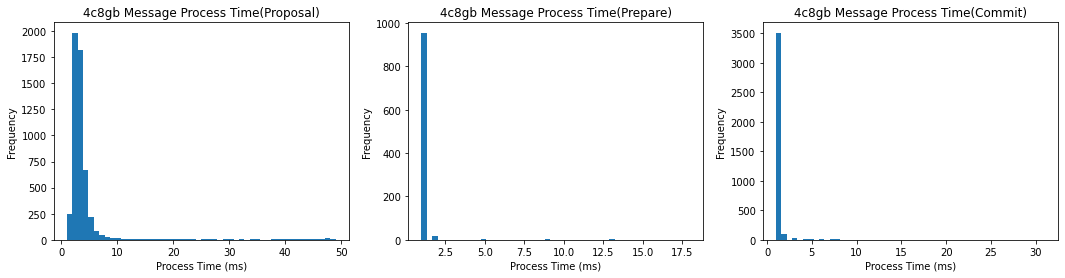

In [8]:
t_process_proposal, t_process_prepare, t_process_commit = cal_process_time(df1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = '4c8gb Message Process Time'
plot_hist(t_process_proposal, axs[0], 50, title+'(Proposal)')
plot_hist(t_process_prepare, axs[1], 50, title+'(Prepare)')
plot_hist(t_process_commit, axs[2], 50, title+'(Commit)')

plt.show()

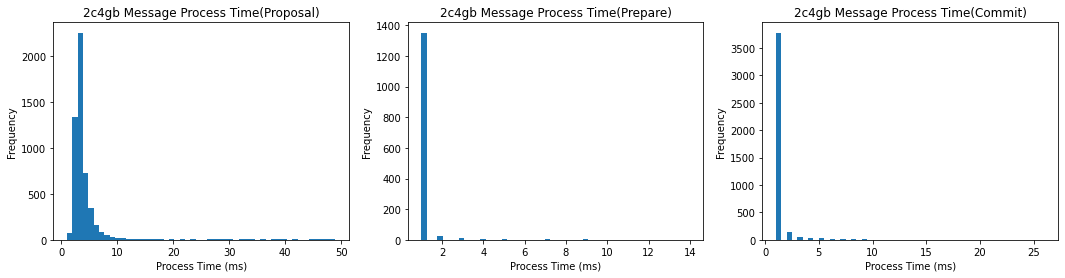

In [9]:
t_process_proposal, t_process_prepare, t_process_commit = cal_process_time(df2)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = '2c4gb Message Process Time'
plot_hist(t_process_proposal, axs[0], 50, title+'(Proposal)')
plot_hist(t_process_prepare, axs[1], 50, title+'(Prepare)')
plot_hist(t_process_commit, axs[2], 50, title+'(Commit)')

plt.show()

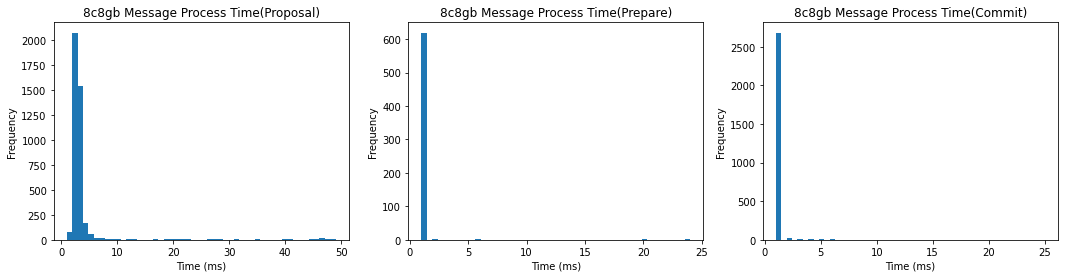

In [73]:
t_process_proposal, t_process_prepare, t_process_commit = cal_process_time(df3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = '8c8gb Message Process Time'
upper, bins = 50, 50
plot_hist(t_process_proposal, axs[0], upper, bins, title+'(Proposal)')
plot_hist(t_process_prepare, axs[1], upper, bins, title+'(Prepare)')
plot_hist(t_process_commit, axs[2], upper, bins, title+'(Commit)')

plt.show()

In [12]:
sum(ts_pro_trans_4c8gb)/len(ts_pro_trans_4c8gb)

0.01760452162516418

In [13]:
sum(ts_prep_trans_4c8gb)/len(ts_prep_trans_4c8gb)

0.008339275064608166

In [14]:
sum(ts_commit_trans_4c8gb)/len(ts_commit_trans_4c8gb)

0.007976859263571601

# Explore Consensus Time

In [58]:
consensus_time_4c8gb = cal_consensus_time(df1)
consensus_time_2c4gb = cal_consensus_time(df2)
consensus_time_8c8gb = cal_consensus_time(df3)

In [61]:
len([t for t in consensus_time_4c8gb if t < 0.4])/len(consensus_time_4c8gb)

0.9842829076620825

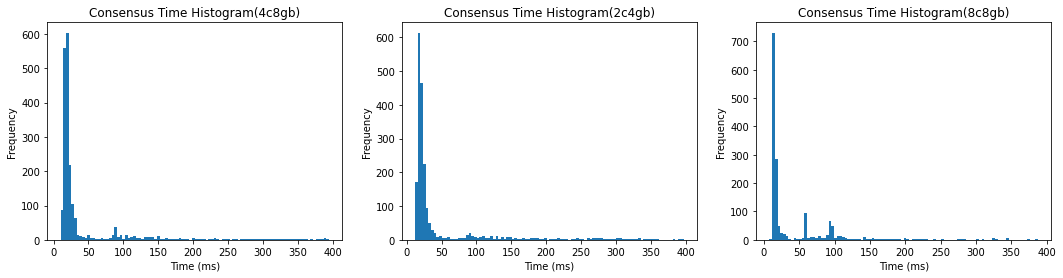

In [63]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Consensus Time Histogram'
upper = 400
bins = 100
plot_hist(consensus_time_4c8gb, axs[0], upper, bins, title+'(4c8gb)')
plot_hist(consensus_time_2c4gb, axs[1], upper, bins, title+'(2c4gb)')
plot_hist(consensus_time_8c8gb, axs[2], upper, bins, title+'(8c8gb)')

plt.show()

In [64]:
sum(consensus_time_4c8gb)/len(consensus_time_4c8gb)

0.06444449901768215

# Scipy Fits Commit Transmit Time

In [16]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def plot_fitting(ts, threshold, title):
    # Load data from statsmodels datasets
    # data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
    data = pd.Series([1000*t for t in ts if t > 0 and 1000*t <= threshold])
    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_distibutions = best_fit_distribution(data, 200, ax)
    best_dist = best_distibutions[0]

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_title(u'{}.\n All Fitted Distributions'.format(title))
    ax.set_xlabel(u'Time (ms)')
    ax.set_ylabel('Frequency')

    # Make PDF with best params 
    pdf = make_pdf(best_dist[0], best_dist[1])

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)

    ax.set_title(u'{} with Best Fit Distribution \n {}'.format(title,dist_str))
    ax.set_xlabel(u'Time (ms)')
    ax.set_ylabel('Frequency')

  1 / 104: ksone
  2 / 104: kstwo
  3 / 104: kstwobign
  4 / 104: norm
  5 / 104: alpha
  6 / 104: anglit
  7 / 104: arcsine
  8 / 104: beta
  9 / 104: betaprime
 10 / 104: bradford
 11 / 104: burr
 12 / 104: burr12
 13 / 104: fisk
 14 / 104: cauchy
 15 / 104: chi
 16 / 104: chi2
 17 / 104: cosine
 18 / 104: dgamma
 19 / 104: dweibull
 20 / 104: expon
 21 / 104: exponnorm
 22 / 104: exponweib
 23 / 104: exponpow
 24 / 104: fatiguelife
 25 / 104: foldcauchy
 26 / 104: f
 27 / 104: foldnorm
 28 / 104: weibull_min
 29 / 104: weibull_max
 30 / 104: genlogistic
 31 / 104: genpareto
 32 / 104: genexpon
 33 / 104: genextreme
 34 / 104: gamma
 35 / 104: erlang
 36 / 104: gengamma
 37 / 104: genhalflogistic
 38 / 104: genhyperbolic
 39 / 104: gompertz
 40 / 104: gumbel_r
 41 / 104: gumbel_l
 42 / 104: halfcauchy
 43 / 104: halflogistic
 44 / 104: halfnorm
 45 / 104: hypsecant
 46 / 104: gausshyper
 47 / 104: invgamma
 48 / 104: invgauss
 49 / 104: geninvgauss
 50 / 104: norminvgauss
 51 / 104: 

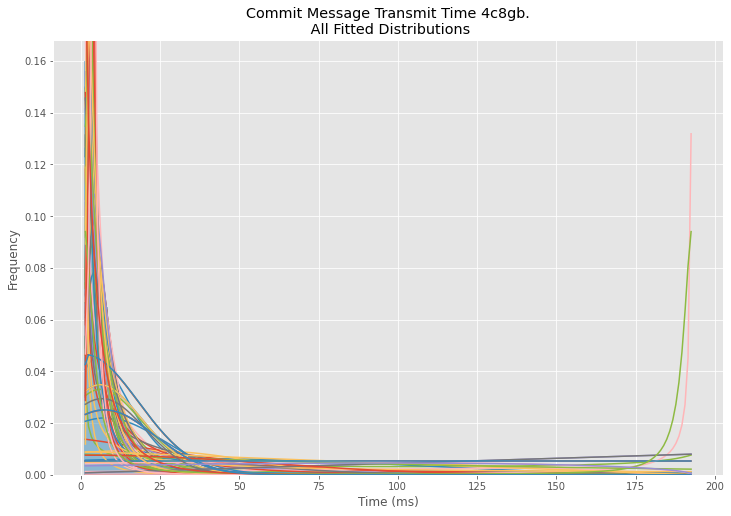

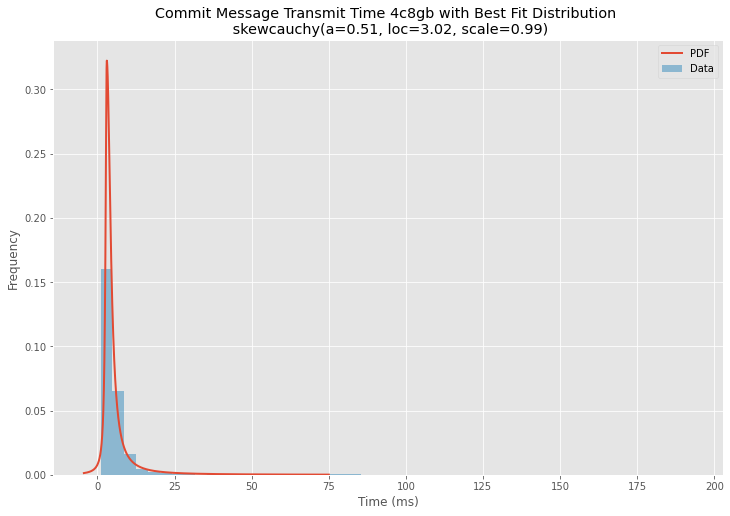

In [53]:
plot_fitting(ts_commit_trans_4c8gb, 200, 'Commit Message Transmit Time 4c8gb')

In [17]:
data = pd.Series([1000*t for t in ts_commit_trans_4c8gb if t > 0 and 1000*t <= 200])
st.kstest(data, 'skewcauchy', (0.51, 3.02, 0.99), len(data))

KstestResult(statistic=0.19291523164421684, pvalue=0.0)

  1 / 104: ksone
  2 / 104: kstwo
  3 / 104: kstwobign
  4 / 104: norm
  5 / 104: alpha
  6 / 104: anglit
  7 / 104: arcsine
  8 / 104: beta
  9 / 104: betaprime
 10 / 104: bradford
 11 / 104: burr
 12 / 104: burr12
 13 / 104: fisk
 14 / 104: cauchy
 15 / 104: chi
 16 / 104: chi2
 17 / 104: cosine
 18 / 104: dgamma
 19 / 104: dweibull
 20 / 104: expon
 21 / 104: exponnorm
 22 / 104: exponweib
 23 / 104: exponpow
 24 / 104: fatiguelife
 25 / 104: foldcauchy
 26 / 104: f
 27 / 104: foldnorm
 28 / 104: weibull_min
 29 / 104: weibull_max
 30 / 104: genlogistic
 31 / 104: genpareto
 32 / 104: genexpon
 33 / 104: genextreme
 34 / 104: gamma
 35 / 104: erlang
 36 / 104: gengamma
 37 / 104: genhalflogistic
 38 / 104: genhyperbolic
 39 / 104: gompertz
 40 / 104: gumbel_r
 41 / 104: gumbel_l
 42 / 104: halfcauchy
 43 / 104: halflogistic
 44 / 104: halfnorm
 45 / 104: hypsecant
 46 / 104: gausshyper
 47 / 104: invgamma
 48 / 104: invgauss
 49 / 104: geninvgauss
 50 / 104: norminvgauss
 51 / 104: 

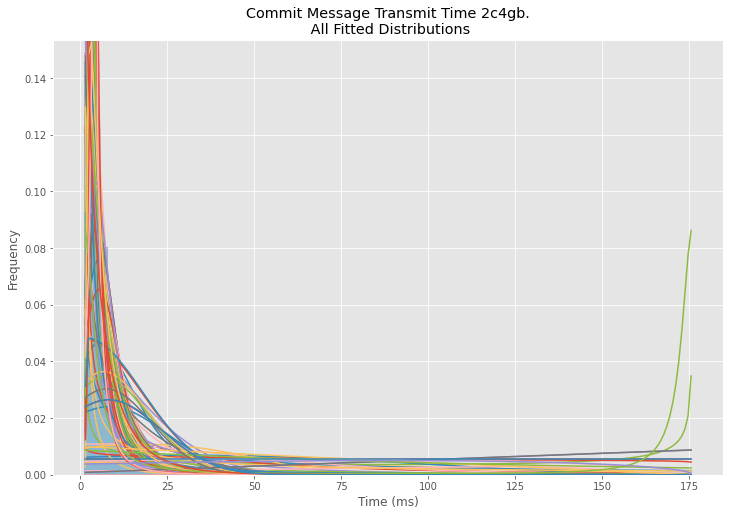

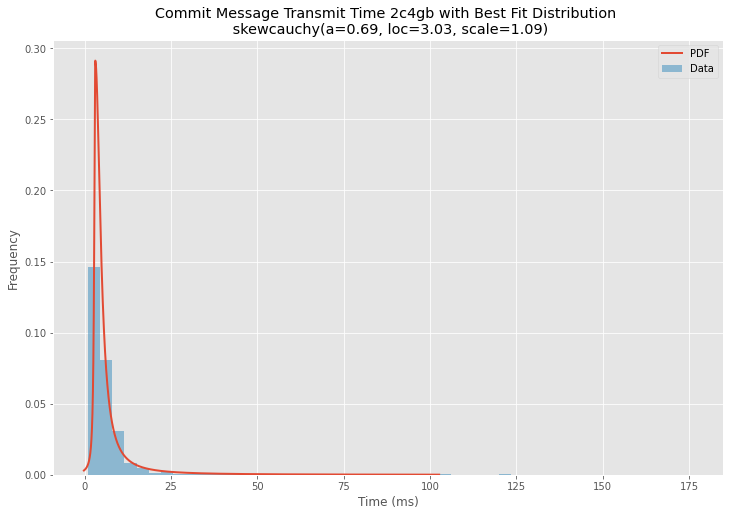

In [18]:
plot_fitting(ts_commit_trans_2c4gb, 200, 'Commit Message Transmit Time 2c4gb')

In [25]:
data = pd.Series([1000*t for t in ts_commit_trans_2c4gb if t > 0 and 1000*t <= 200])
print(st.kstest(data, 'skewcauchy', (0.69, 3.03, 1.09), len(data)))

KstestResult(statistic=0.15971865962897103, pvalue=6.577708221638216e-283)


# distfit Commit Message Transmit Time

In [21]:
trans_ts = [ts_prep_trans_2c4gb, ts_prep_trans_4c8gb, ts_prep_trans_8c8gb,
            ts_pro_trans_2c4gb, ts_pro_trans_4c8gb, ts_pro_trans_8c8gb,
            ts_commit_trans_2c4gb, ts_commit_trans_4c8gb, ts_commit_trans_8c8gb]
for ts in trans_ts:            
    data = pd.Series([1000*t for t in ts if t > 0 and 1000*t <= 50])
    print(len(data)/len(ts))

0.9707856296881169
0.973891723543834
0.9767580898288618
0.992
0.9908256880733946
0.9812932086213908
0.9713159968479117
0.9735118614466599
0.974606522797339


[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.1018499] [loc=8.044 scale=6.838]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0918347] [loc=2.000 scale=6.044]
[distfit] >[pareto    ] [0.51 sec] [RSS: 0.1738952] [loc=-0.005 scale=2.005]
[distfit] >[dweibull  ] [0.95 sec] [RSS: 0.0522083] [loc=5.000 scale=5.649]
[distfit] >[t         ] [0.21 sec] [RSS: 0.0069763] [loc=5.283 scale=1.073]
[distfit] >[genextreme] [0.97 sec] [RSS: 0.0222767] [loc=5.157 scale=1.841]
[distfit] >[gamma     ] [0.47 sec] [RSS: 0.0615159] [loc=1.999 scale=3.794]
[distfit] >[lognorm   ] [0.25 sec] [RSS: 0.0371577] [loc=1.982 scale=4.302]
[distfit] >[beta      ] [0.54 sec] [RSS: 0.0620281] [loc=1.999 scale=903763.948]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.1444124] [loc=2.000 scale=48.000]
[distfit] >[loggamma  ] [0.21 sec] [RSS: 0.1041881] [loc=-2061.623 scale=282.030]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[0.96 5.28 1.07]
KstestResult(statistic=0

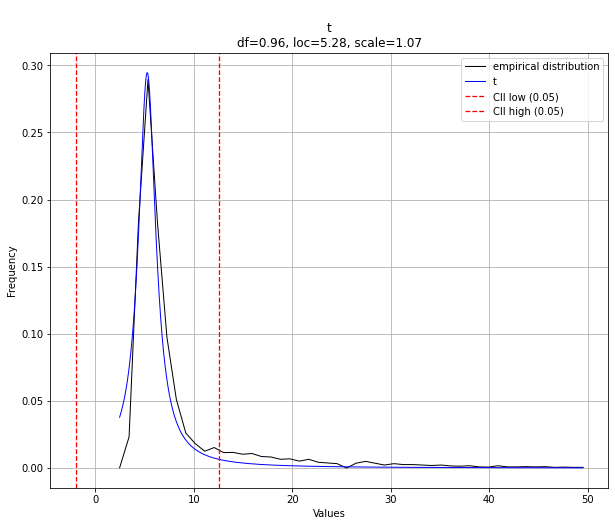

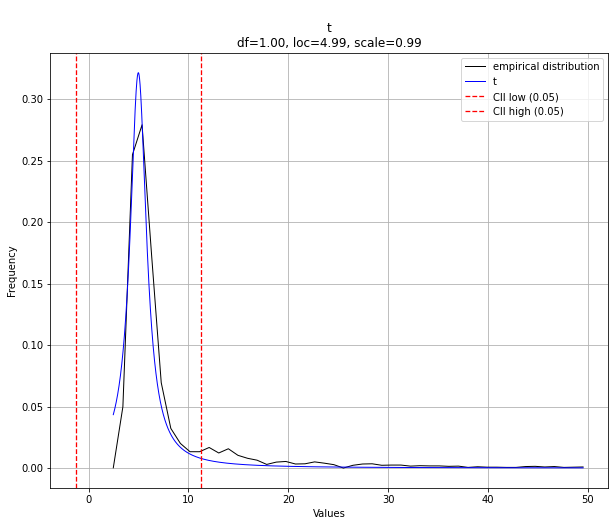

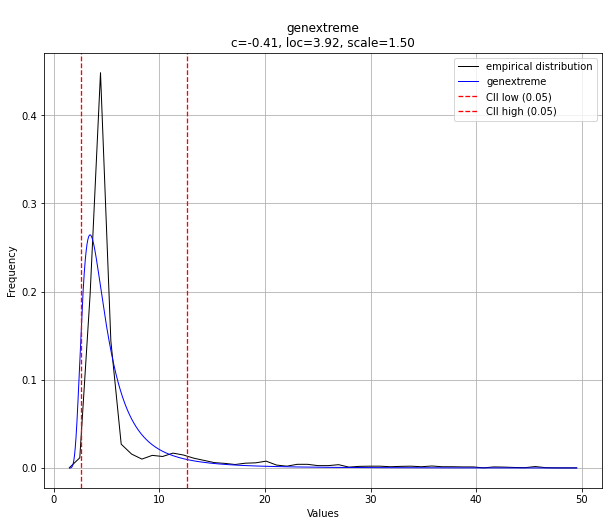

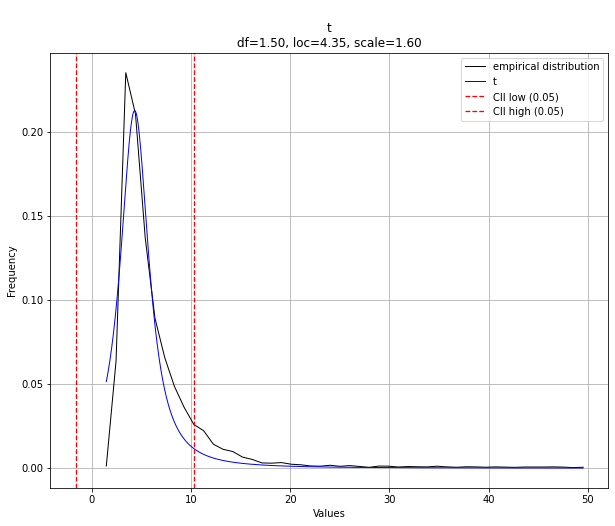

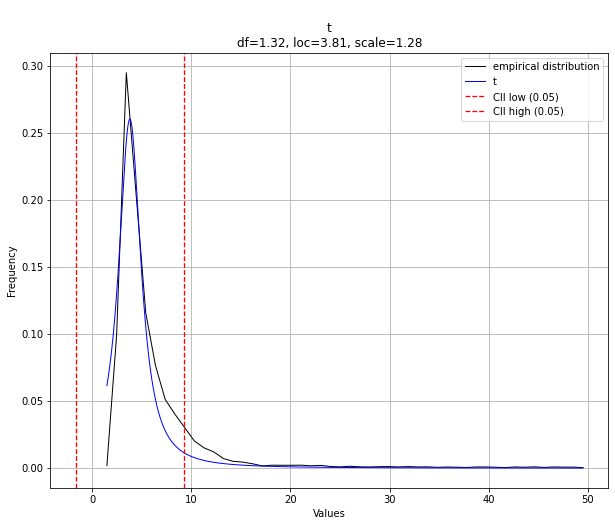

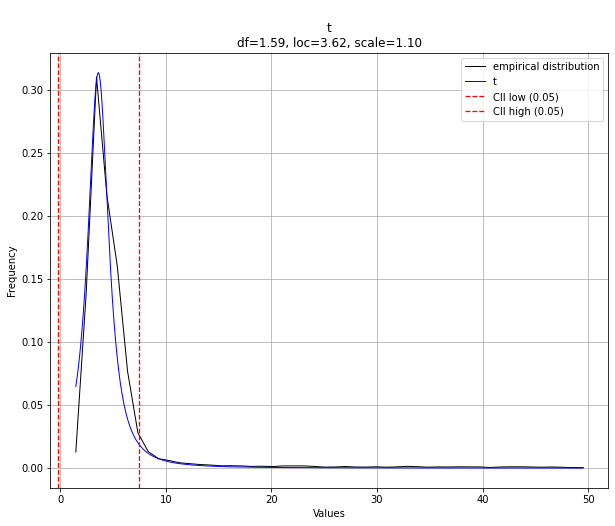

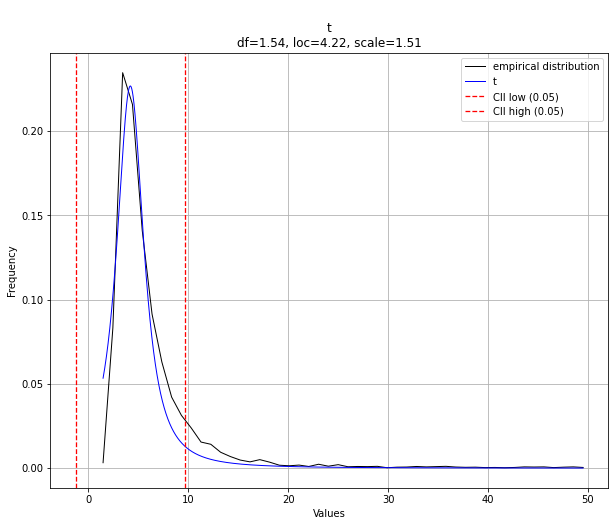

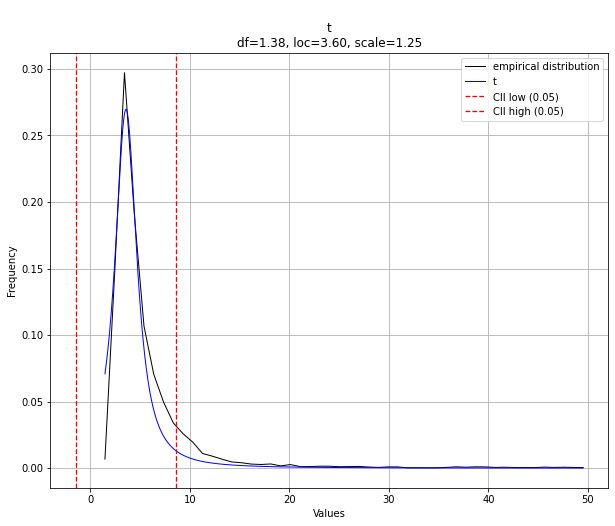

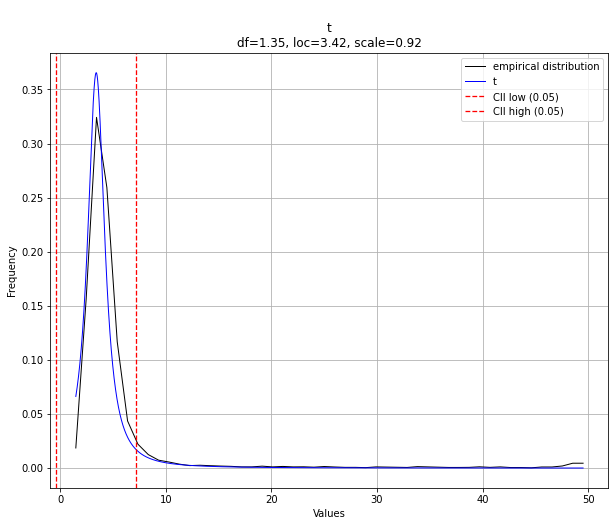

In [30]:
from distfit import distfit
import scipy.stats as st

trans_ts = [ts_pro_trans_2c4gb, ts_pro_trans_4c8gb, ts_pro_trans_8c8gb,
            ts_prep_trans_2c4gb, ts_prep_trans_4c8gb, ts_prep_trans_8c8gb,
            ts_commit_trans_2c4gb, ts_commit_trans_4c8gb, ts_commit_trans_8c8gb]
for ts in trans_ts:            
    data = pd.Series([1000*t for t in ts if t > 0 and 1000*t <= 50])
    dist = distfit()
    dist.fit_transform(data)
    dist.plot()
    if dist.model['name'] == 't':
        params = dist.model['params']
        print(np.round(params, 2))
        print(st.kstest(data, 't', params))


In [8]:
print(dist.summary)

         distr     score  LLE          loc        scale  \
0      lognorm  0.000498  NaN     0.914303     4.062867   
1            t  0.001178  NaN      4.15144     1.416397   
2        expon  0.002028  NaN          1.0     7.228129   
3         beta  0.002068  NaN          1.0  2911.422863   
4       pareto  0.002435  NaN    -0.724564     1.724564   
5   genextreme  0.002864  NaN      3.83134     2.033848   
6     dweibull   0.01022  NaN          4.0     8.140134   
7        gamma  0.015645  NaN          1.0    10.408767   
8         norm  0.018503  NaN     8.228129    15.042968   
9     loggamma  0.018984  NaN -4909.900507   660.242119   
10     uniform  0.026705  NaN          1.0        175.0   

                                         arg  
0                      (0.8888384022243354,)  
1                      (1.0893122358026885,)  
2                                         ()  
3   (0.9402406641937897, 375.78754236688786)  
4                      (0.7080638202373337,)  
5        

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.1128354] [loc=7.402 scale=6.548]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0990892] [loc=2.000 scale=5.402]
[distfit] >[pareto    ] [0.44 sec] [RSS: 0.1850495] [loc=-0.003 scale=2.003]
[distfit] >[dweibull  ] [0.87 sec] [RSS: 0.0954141] [loc=4.000 scale=6.154]
[distfit] >[t         ] [0.10 sec] [RSS: 0.0083994] [loc=4.987 scale=0.990]
[distfit] >[genextreme] [0.44 sec] [RSS: 0.0293651] [loc=4.761 scale=1.647]
[distfit] >[gamma     ] [0.07 sec] [RSS: 0.0679701] [loc=1.999 scale=3.560]
[distfit] >[lognorm   ] [0.12 sec] [RSS: 0.0403030] [loc=1.985 scale=3.773]
[distfit] >[beta      ] [0.40 sec] [RSS: 0.0491975] [loc=1.997 scale=42698813497845.453]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.1609911] [loc=2.000 scale=48.000]
[distfit] >[loggamma  ] [0.15 sec] [RSS: 0.1137302] [loc=-2755.839 scale=349.069]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >fit..
[distfit] >trans

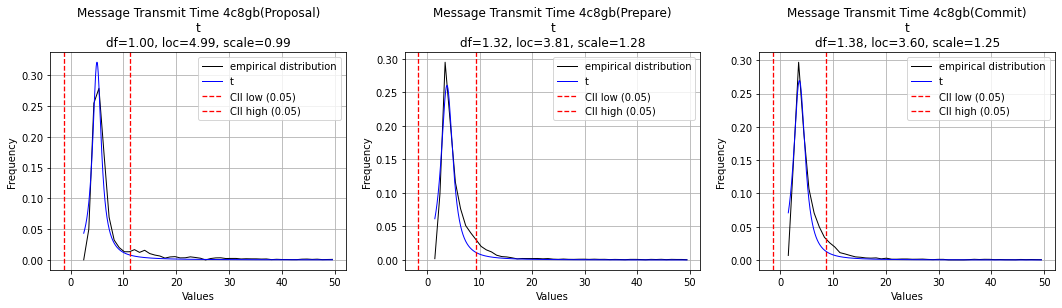

In [6]:
from distfit import distfit
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = "Message Transmit Time 4c8gb"

dist1 = distfit()
data1 = pd.Series([1000*t for t in ts_pro_trans_4c8gb if t > 0 and 1000*t <= 50])
dist1.fit_transform(data1)
dist1.plot(title=title+'(Proposal)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[0], verbose=3)

dist2 = distfit()
data2 = pd.Series([1000*t for t in ts_prep_trans_4c8gb if t > 0 and 1000*t <= 50])
dist2.fit_transform(data2)
dist2.plot(title=title+'(Prepare)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[1], verbose=3)

dist3 = distfit()
data3 = pd.Series([1000*t for t in ts_commit_trans_4c8gb if t > 0 and 1000*t <= 50])
dist3.fit_transform(data3)
dist3.plot(title=title+'(Commit)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[2], verbose=3)

plt.show()

[distfit] >plot summary..


(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Best fit: lognorm'}, xlabel='Distribution name', ylabel='RSS (lower is better)'>)

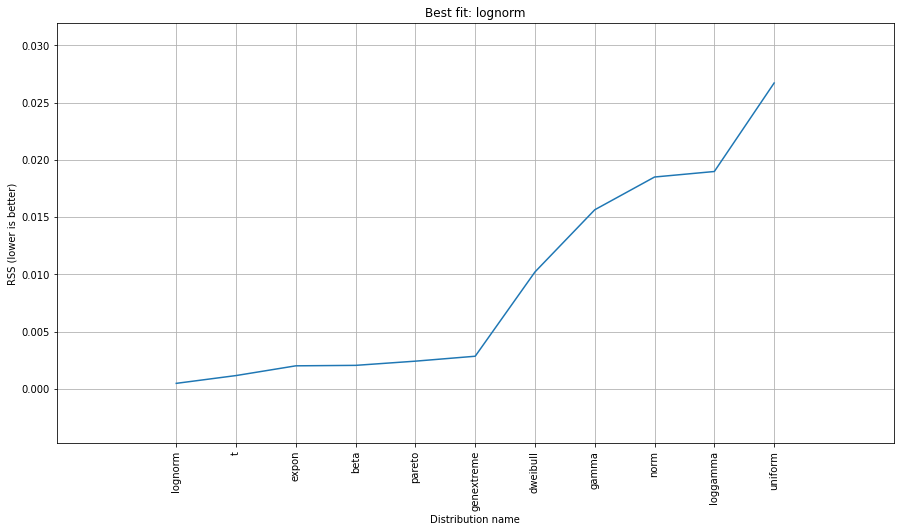

In [10]:
dist.plot_summary()

[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nlognorm\ns=0.89, loc=0.91, scale=4.06'}, xlabel='Values', ylabel='Frequency'>)

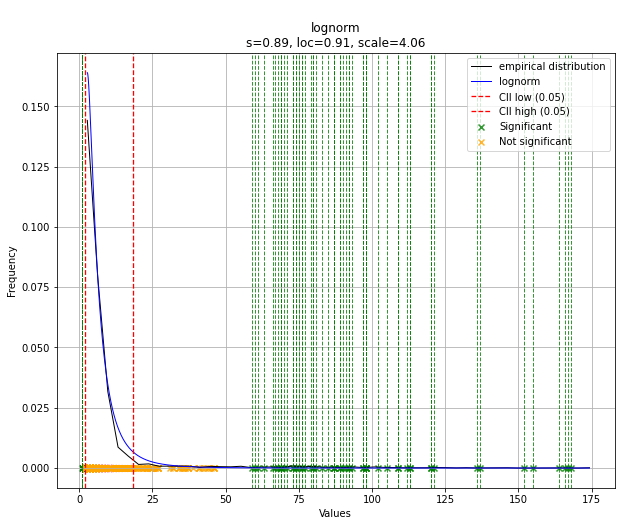

In [13]:
dist.plot()

# distfit Fitting Consensus Time

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0113328] [loc=30.858 scale=32.583]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0065244] [loc=10.000 scale=20.858]
[distfit] >[pareto    ] [0.66 sec] [RSS: 0.0094017] [loc=-0.042 scale=10.042]
[distfit] >[dweibull  ] [0.54 sec] [RSS: 0.0036492] [loc=19.000 scale=19.392]
[distfit] >[t         ] [0.49 sec] [RSS: 0.0009141] [loc=18.281 scale=2.805]
[distfit] >[genextreme] [1.42 sec] [RSS: 0.0012403] [loc=17.763 scale=5.649]
[distfit] >[gamma     ] [0.44 sec] [RSS: 0.0068340] [loc=10.000 scale=23.391]
[distfit] >[lognorm   ] [0.38 sec] [RSS: 0.0033735] [loc=9.903 scale=11.427]
[distfit] >[beta      ] [0.95 sec] [RSS: 0.0068035] [loc=10.000 scale=3400.366]
[distfit] >[uniform   ] [0.02 sec] [RSS: 0.0134930] [loc=10.000 scale=184.000]
[distfit] >[loggamma  ] [0.36 sec] [RSS: 0.0115116] [loc=-15128.673 scale=1894.767]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >fit..
[distfit]

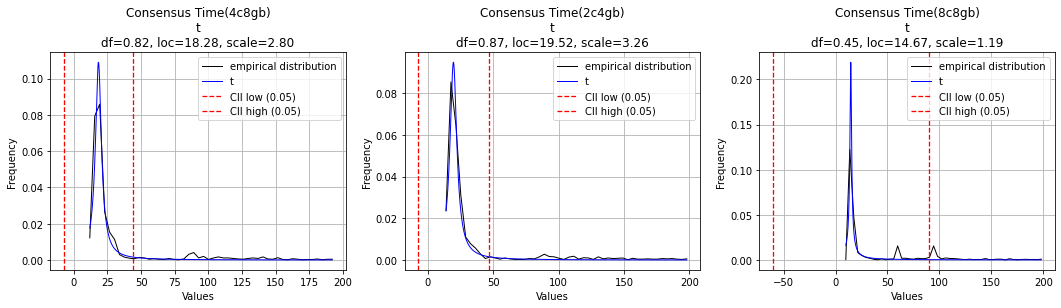

In [76]:
from distfit import distfit
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = "Consensus Time"

dist1 = distfit()
data1 = pd.Series([1000*t for t in consensus_time_4c8gb if t > 0 and 1000*t <= 200])
dist1.fit_transform(data1)
dist1.plot(title=title+'(4c8gb)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[0], verbose=3)

dist2 = distfit()
data2 = pd.Series([1000*t for t in consensus_time_2c4gb if t > 0 and 1000*t <= 200])
dist2.fit_transform(data2)
dist2.plot(title=title+'(2c4gb)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[1], verbose=3)

dist3 = distfit()
data3 = pd.Series([1000*t for t in consensus_time_8c8gb if t > 0 and 1000*t <= 200])
dist3.fit_transform(data3)
dist3.plot(title=title+'(8c8gb)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[2], verbose=3)

plt.show()

In [69]:
dist.model['params']

(0.8227136335196061, 18.280586317123674, 2.804599247578384)

[distfit] >plot summary..


(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Best fit: t'}, xlabel='Distribution name', ylabel='RSS (lower is better)'>)

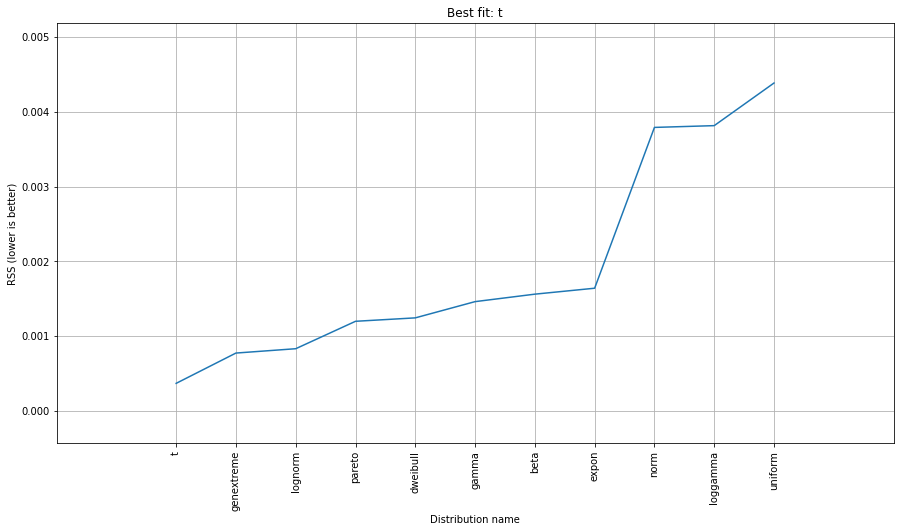

In [67]:
dist.plot_summary()

In [30]:
log_path_4nodes = '../data/logs-20220125-182415-4nodes'
df_4nodes = gen_logs_df(logpath=log_path_4nodes, networksize=4)
log_path_8nodes = '../data/logs-20220125-204841-8nodes'
df_8nodes = gen_logs_df(logpath=log_path_8nodes, networksize=8)
log_path_6nodes = '../data/logs-20220125-221756-6nodes'
df_6nodes = gen_logs_df(logpath=log_path_6nodes, networksize=6)

In [32]:
df_6nodes.Node.unique()

array([1, 2, 3, 4, 5, 6])

In [24]:
# log_path_8nodes = '../data/logs-20220125-234435-8nodes'
# df_8nodes_2 = gen_logs_df(logpath=log_path_8nodes, networksize=8)

In [33]:
consensus_time_4nodes = cal_consensus_time(df_4nodes)
consensus_time_6nodes = cal_consensus_time(df_6nodes)
consensus_time_8nodes = cal_consensus_time(df_8nodes)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.15 sec] [RSS: 0.0074829] [loc=20.839 scale=24.453]
[distfit] >[expon     ] [0.01 sec] [RSS: 0.0040672] [loc=4.000 scale=16.839]
[distfit] >[pareto    ] [0.37 sec] [RSS: 0.0087277] [loc=-0.015 scale=4.015]
[distfit] >[dweibull  ] [1.50 sec] [RSS: 0.0032124] [loc=10.000 scale=7.995]
[distfit] >[t         ] [0.93 sec] [RSS: 0.0039490] [loc=12.746 scale=6.292]
[distfit] >[genextreme] [1.23 sec] [RSS: 0.0014908] [loc=10.862 scale=5.414]
[distfit] >[gamma     ] [3.09 sec] [RSS: 0.0106623] [loc=4.000 scale=4.506]
[distfit] >[lognorm   ] [0.68 sec] [RSS: 0.0024479] [loc=3.907 scale=10.205]
[distfit] >[beta      ] [9.04 sec] [RSS: 0.0037253] [loc=3.998 scale=21654111348519.258]
[distfit] >[uniform   ] [0.01 sec] [RSS: 0.0110210] [loc=4.000 scale=195.000]
[distfit] >[loggamma  ] [4.35 sec] [RSS: 0.0077064] [loc=-11101.972 scale=1400.389]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >fit..
[distf

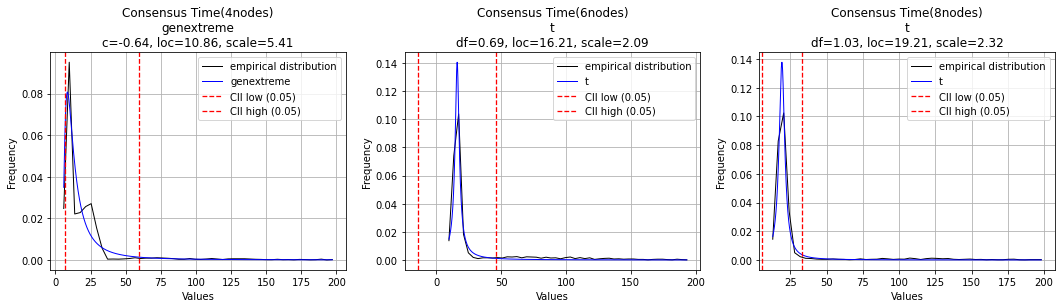

In [34]:
from distfit import distfit
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = "Consensus Time"

dist1 = distfit()
data1 = pd.Series([1000*t for t in consensus_time_4nodes if t > 0 and 1000*t <= 200])
dist1.fit_transform(data1)
dist1.plot(title=title+'(4nodes)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[0], verbose=3)

dist2 = distfit()
data2 = pd.Series([1000*t for t in consensus_time_6nodes if t > 0 and 1000*t <= 200])
dist2.fit_transform(data2)
dist2.plot(title=title+'(6nodes)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[1], verbose=3)

dist3 = distfit()
data3 = pd.Series([1000*t for t in consensus_time_8nodes if t > 0 and 1000*t <= 200])
dist3.fit_transform(data3)
dist3.plot(title=title+'(8nodes)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[2], verbose=3)

plt.show()

In [5]:
np.mean(consensus_time_4nodes)

0.03821391138637447

In [12]:
np.mean(consensus_time_6nodes)

0.0392463389121339

In [6]:
np.mean(consensus_time_8nodes)

0.061741736694677876

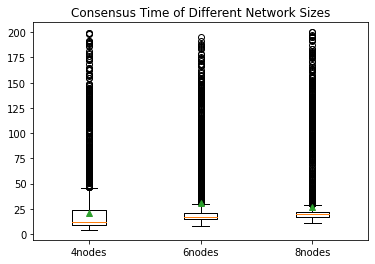

In [35]:
import matplotlib.pyplot as plt
import numpy as np

data1 = pd.Series([1000*t for t in consensus_time_4nodes if t > 0 and 1000*t <= 200])
data2 = pd.Series([1000*t for t in consensus_time_6nodes if t > 0 and 1000*t <= 200])
data3 = pd.Series([1000*t for t in consensus_time_8nodes if t > 0 and 1000*t <= 200])

# data_to_plot = [consensus_time_4nodes,
#                 consensus_time_6nodes,
#                 consensus_time_8nodes]
data_to_plot = [data1, data2, data3]
positions = np.arange(3) + 1

fig, ax = plt.subplots(figsize=(6,4))

# matplotlib > 1.4
labels = ['4nodes', '6nodes', '8nodes']
bp = ax.boxplot(data_to_plot, positions=positions, showmeans=True, labels=labels)
ax.set_title("Consensus Time of Different Network Sizes")

# #matpltolib < 1.4
# bp = ax[1].boxplot(data_to_plot, positions=positions)
# means = [np.mean(data) for data in data_to_plot.T]
# ax[1].plot(positions, means, 'rs')
# ax[1].set_title("Plotting means manually")

plt.show()

In [21]:
np.mean(data1)

20.83884099616858

In [22]:
np.mean(data2)

28.98367561874671

In [23]:
np.mean(data3)

23.501005458201668